In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

from dataloaders.osm_dataloader import OSMDataset
from dataloaders.osm_datagenerator import DataGeneratorOSM
from dataloaders.dataset_helper import findallimagesosm

from models.Unet_keras import buildUnet
from dataloaders.img_helper import show_sample, show_sample_gt


Using TensorFlow backend.


In [2]:
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#functions for the loss
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

# Dataset loading

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


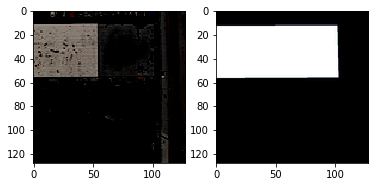

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


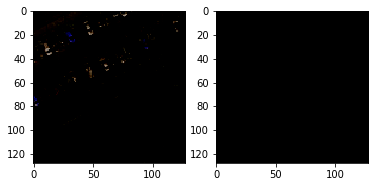

In [12]:
 # Datasets
partition, labels = findallimagesosm(folder = '/data/khokhlov/datasets/OSM_processed_margo/')

params = {'dim': (128, 128),
          'batch_size': 86,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': True}
max_epochs = 100

training_generator = DataGeneratorOSM(partition['train'], labels['train'], **params)
validation_generator = DataGeneratorOSM(partition['validation'], labels['validation'], **params)

(X,y) = training_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))

(X,y) = validation_generator. __getitem__(0)
show_sample(X[0,:].astype(int), np.squeeze(y[0,:]))


## Training parameters

In [10]:
loss_history = []
weight_path = "modelssaved/{}_weights.best.hdf5".format('vgg_unet')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)  # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]




## Model

In [13]:
unet_model = buildUnet(X, y) # to initialize the parameters correctly
unet_model.compile(optimizer=Adam(1e-3, decay=1e-4),
                   loss=binary_crossentropy,
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [14]:

loss_history += [unet_model.fit_generator(generator=training_generator, steps_per_epoch=100,
                                          epochs=50,
                                          validation_data=validation_generator, validation_steps=20,
                                          use_multiprocessing=False,
                                          callbacks=callbacks_list)]

Epoch 1/50
100/100 [==============================] - 324s 3s/step - loss: 0.5063 - dice_coef: 0.5256 - binary_accuracy: 0.7611 - true_positive_rate: 0.6916 - val_loss: 0.4308 - val_dice_coef: 0.4356 - val_binary_accuracy: 0.7882 - val_true_positive_rate: 0.7858

Epoch 00001: val_loss improved from inf to 0.43079, saving model to modelssaved/vgg_unet_weights.best.hdf5
Epoch 2/50
100/100 [==============================] - 291s 3s/step - loss: 0.3517 - dice_coef: 0.5679 - binary_accuracy: 0.8017 - true_positive_rate: 0.7502 - val_loss: 0.4249 - val_dice_coef: 0.4446 - val_binary_accuracy: 0.7973 - val_true_positive_rate: 0.7831

Epoch 00002: val_loss improved from 0.43079 to 0.42493, saving model to modelssaved/vgg_unet_weights.best.hdf5
Epoch 3/50
100/100 [==============================] - 297s 3s/step - loss: 0.3377 - dice_coef: 0.5783 - binary_accuracy: 0.8085 - true_positive_rate: 0.7619 - val_loss: 0.3819 - val_dice_coef: 0.4377 - val_binary_accuracy: 0.8094 - val_true_positive_rate

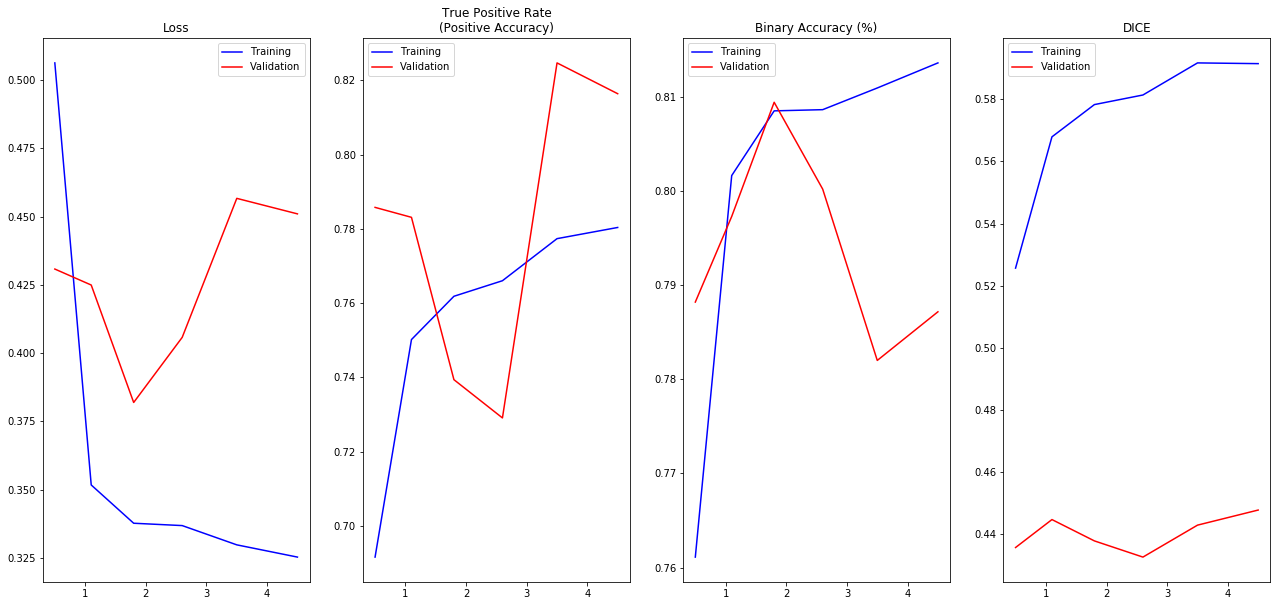

In [15]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [16]:
unet_model.load_weights(weight_path)
unet_model.save('full_seg_model.h5')

## Test Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


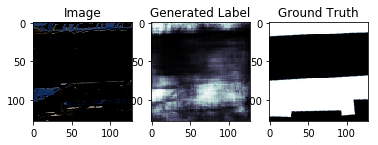

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0025610195 0.9670718


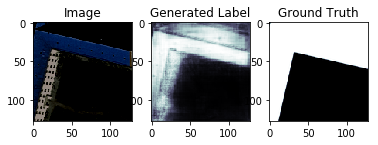

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0026672436 0.9834086


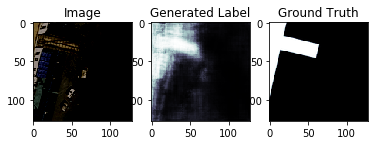

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0015745185 0.99206805


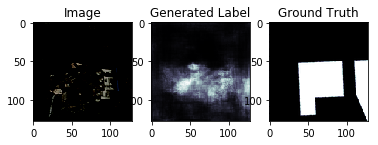

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0020937638 0.91343004


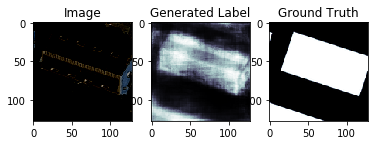

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0022530346 0.9514954


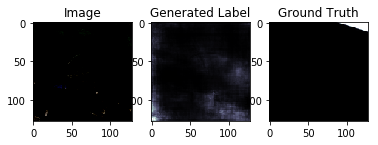

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00073483854 0.6235286


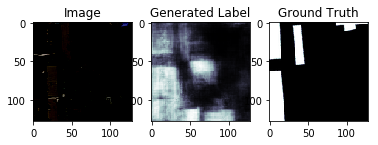

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0031278445 0.9659579


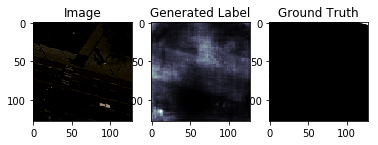

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0020669706 0.7335999


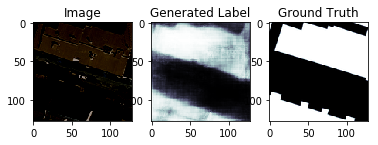

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0015719883 0.9964849


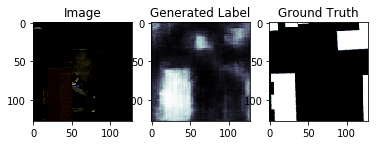

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008211934 0.9723842


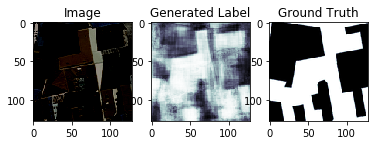

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.07858532 0.99236685


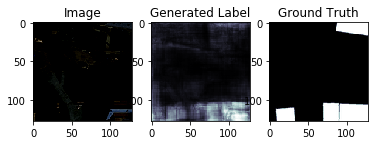

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0041336385 0.93487626


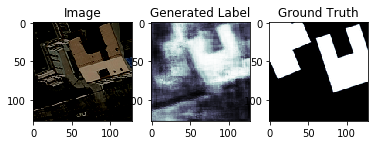

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.032219578 0.98792344


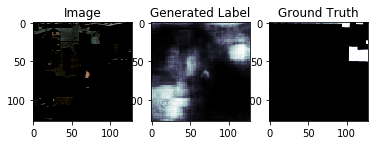

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0009695856 0.9700263


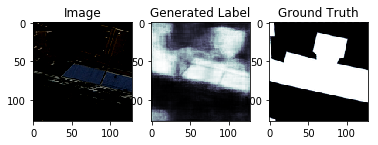

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.006409652 0.97804594


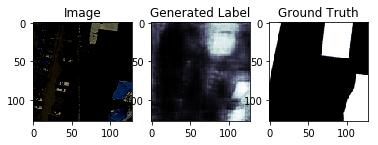

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0024918292 0.9895209


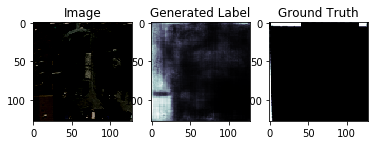

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00028659086 0.9536768


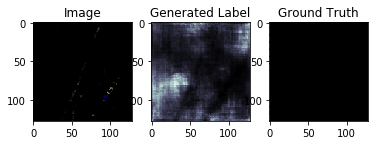

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012092672 0.22485857


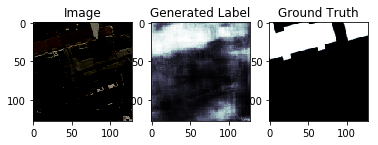

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008408658 0.9663109


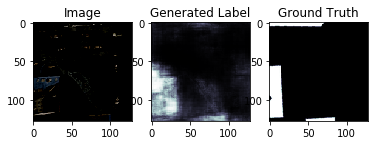

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00090466527 0.9635576


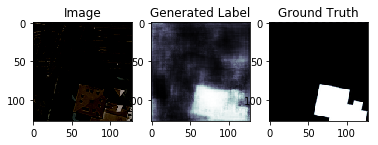

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0063476167 0.9959549


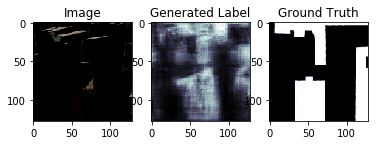

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.009918066 0.89402986


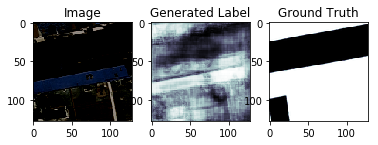

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.034546345 0.98800176


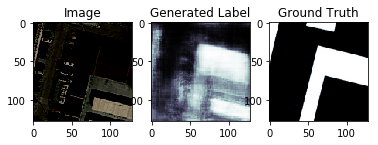

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0027365398 0.9853146


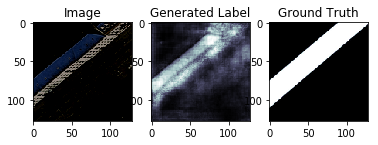

0.023089055 0.94183356


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


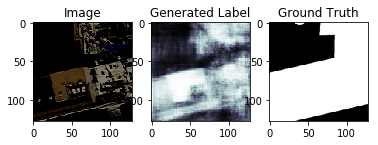

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.015830096 0.9976172


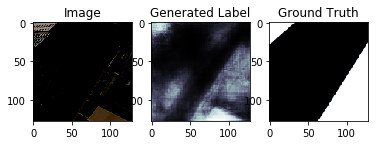

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0034180717 0.96924275


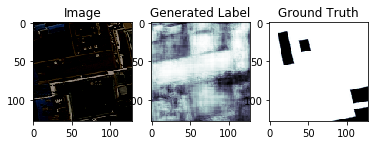

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0918376 0.986584


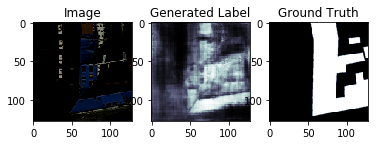

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012539906 0.971299


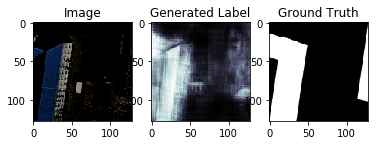

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0071460963 0.9853349


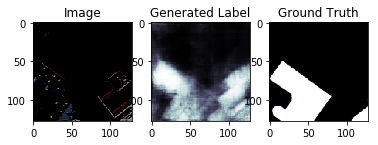

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.013637694 0.99243075


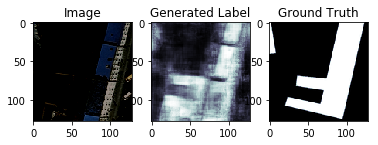

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.024149505 0.9814082


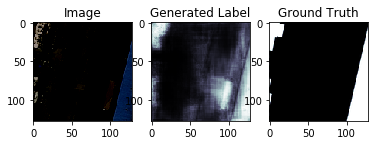

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0020169453 0.9606138


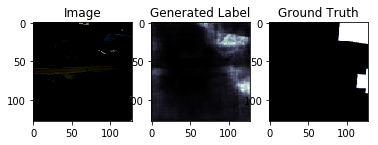

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0009658686 0.75178367


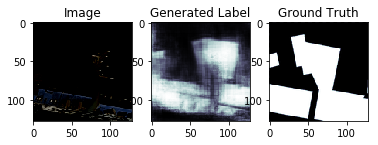

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.006502516 0.9880414


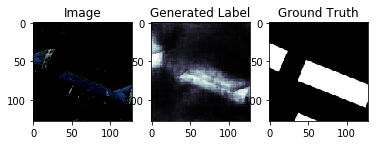

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0037526477 0.9541629


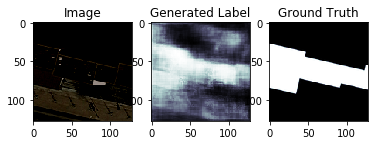

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.03378595 0.9922329


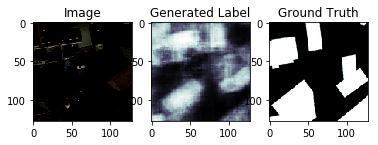

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008853328 0.98784536


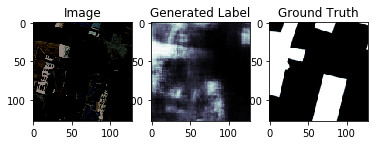

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0009899952 0.97867864


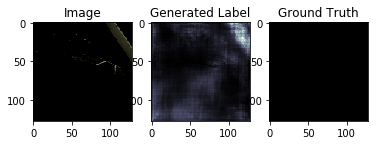

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0025990964 0.3866735


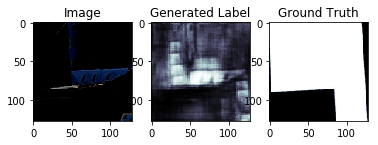

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0041133054 0.9886596


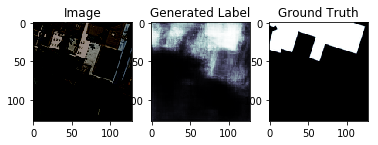

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00033116806 0.9921411


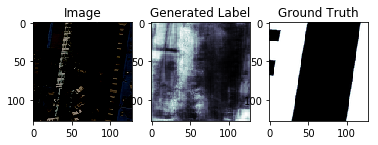

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007279805 0.95184004


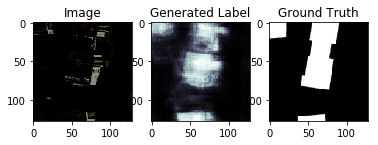

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0023517522 0.976262


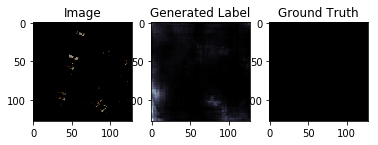

9.429738e-05 0.342575


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


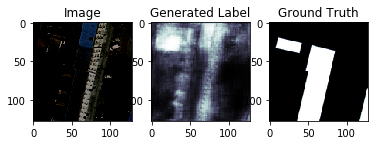

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.005152904 0.9956825


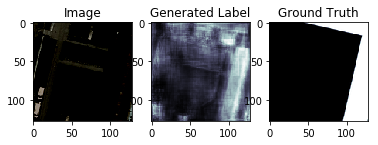

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008473184 0.89437777


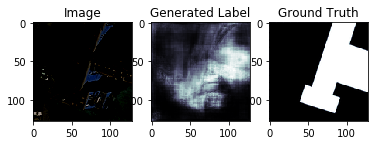

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0013857615 0.9468856


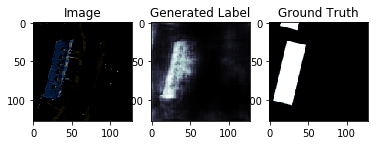

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0007493383 0.9123168


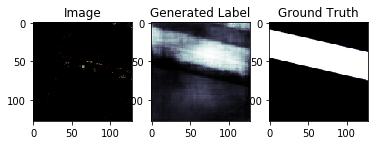

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0013727307 0.95839816


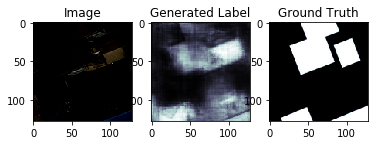

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0058016167 0.9451978


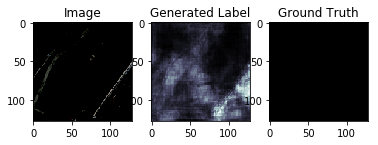

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0072822105 0.61787546


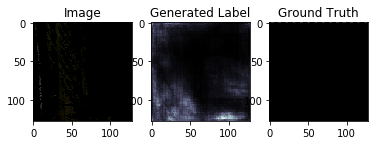

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0016895769 0.3796852


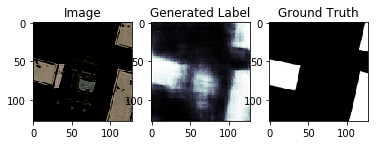

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0019857376 0.9969183


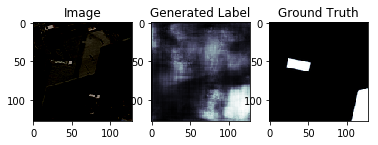

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.008468952 0.9823345


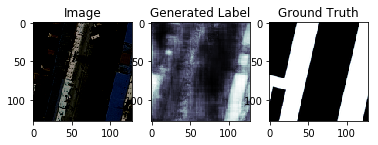

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.014200087 0.9754675


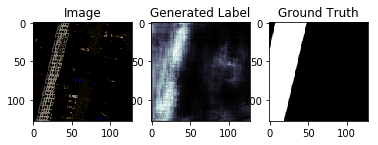

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0014247727 0.9236125


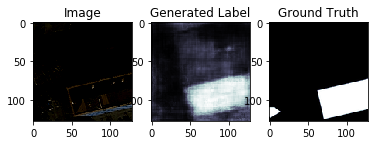

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.009853851 0.9659805


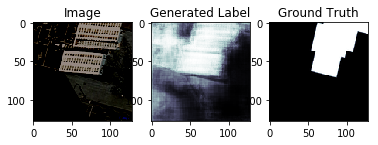

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0010614687 0.99331117


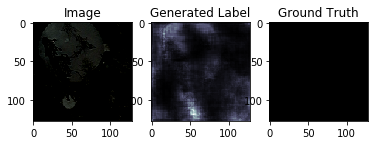

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0025831908 0.29807955


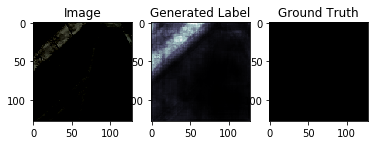

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.001640943 0.6494579


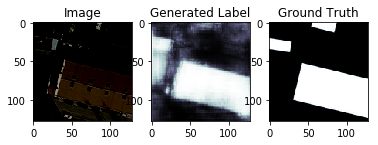

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0012548752 0.9957558


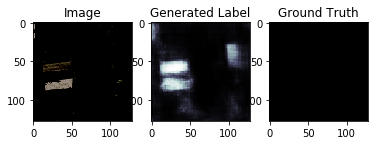

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00066261785 0.99068004


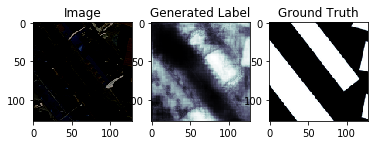

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0008565631 0.9772818


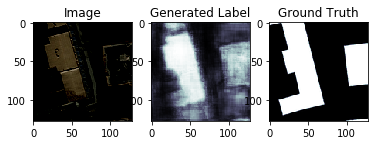

0.009293965 0.99347234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


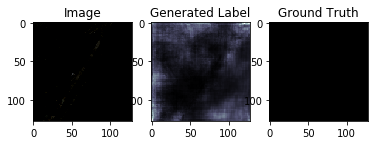

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0028050095 0.23369382


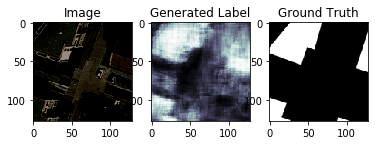

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.018282995 0.9700482


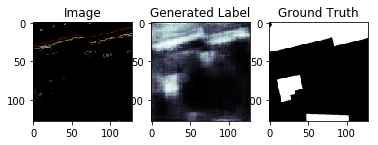

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.006196765 0.9725289


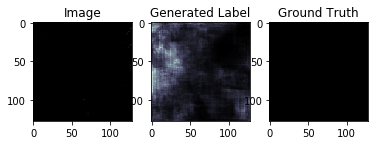

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0016415025 0.4564597


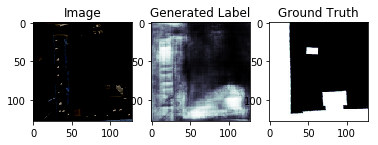

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.011580774 0.9859482


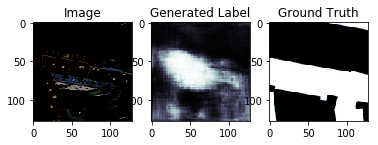

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.004330984 0.99185807


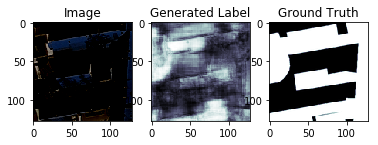

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05128333 0.98003995


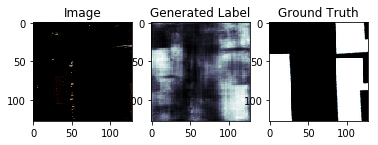

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.021193098 0.931037


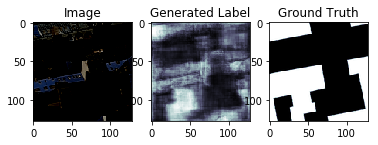

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.021396771 0.9787378


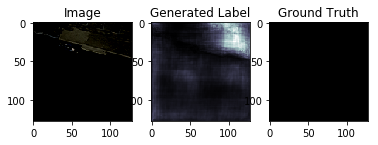

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.003576854 0.65198606


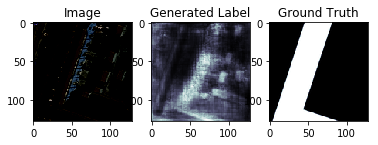

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0070041697 0.8949138


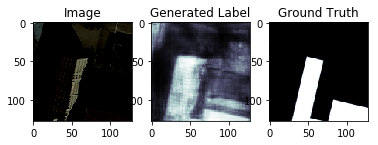

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007935625 0.96084476


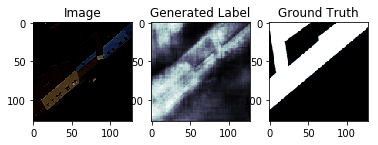

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.011998767 0.9443234


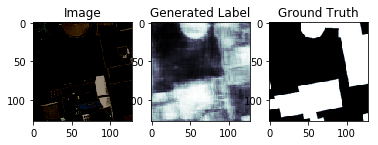

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.009089288 0.9931793


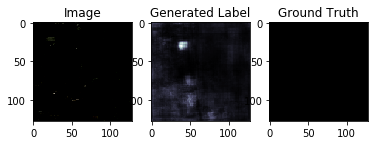

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0051375558 0.6643967


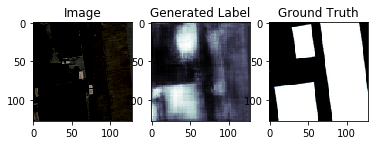

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0103704175 0.9655467


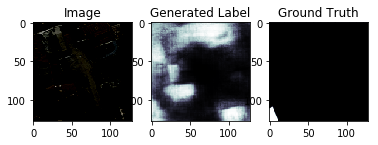

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.00069170963 0.9769497


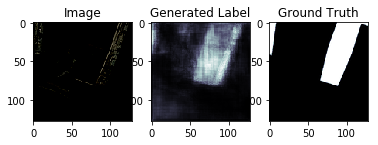

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0025688538 0.84194773


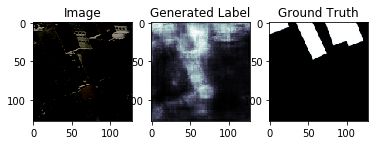

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.007897396 0.96189594


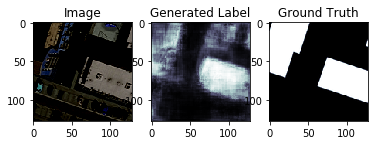

0.0022510504 0.97057927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


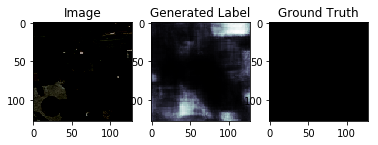

0.0009971405 0.9721415


In [17]:
%load_ext autoreload
%autoreload 2

testing_generator = DataGeneratorOSM(partition['test'], labels['test'], **params)
(X,y) = testing_generator. __getitem__(0)
dm_pred = unet_model.predict([X])
for i in range(dm_pred.shape[0]):
    show_sample_gt(X[i,:].astype(int) + , np.squeeze(dm_pred[i,:]), np.squeeze(y[i,:]))
    print(dm_pred[i,:].min(), dm_pred[i,:].max())
    


In [21]:
# TO DO
# MASK COVERAGE FUNCTION from Maurits - check it
# GENERATE FAKE IMAGES
# MAKE low resolution 128x128
# UNIT test - if masks should be binary. Check values - why the mask is weird? 
# check the loss functions 
# check KERAS Preprocessing



numpy.float64

## evaluate the model results

In [18]:
out_parms = unet_model.evaluate_generator(testing_generator , steps = 10)
print('\n')
for k,v in zip(unet_model.metrics_names, out_parms):
    print(k,'%2.2f' % v)
    



loss 0.36
dice_coef 0.46
binary_accuracy 0.81
true_positive_rate 0.64
